# Using Explainable AI on fish data to identify fish species

We will first explore the fish dataset that has 7 features in it. There are 6 independent measurement features and 1 target feature named "sepecies". We will try to create models to classify fish species

In [1]:
import pandas as pd
df = pd.read_csv("dataset/fish.csv", header=None)
df.columns=["species","A","B","C","D","E","F"]
df.head()

,species,A,B,C,D,E,F
0,Bream,242.0,23.2,25.4,30.0,38.4,13.4
1,Bream,290.0,24.0,26.3,31.2,40.0,13.8
2,Bream,340.0,23.9,26.5,31.1,39.8,15.1
3,Bream,363.0,26.3,29.0,33.5,38.0,13.3
4,Bream,430.0,26.5,29.0,34.0,36.6,15.1


Let us visualize the distribution of the original features


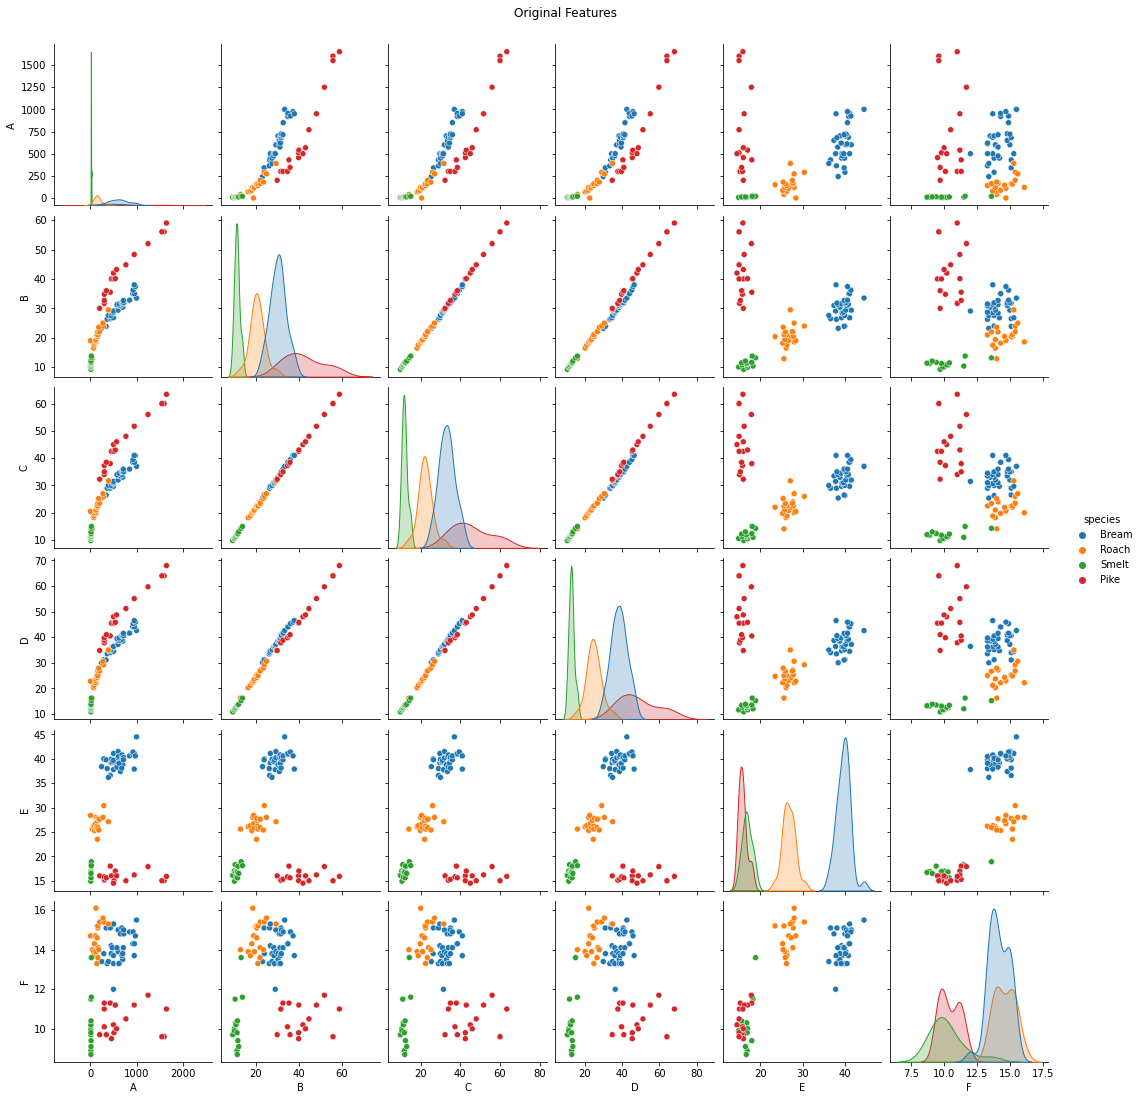

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Original Features
sns.pairplot(df, hue='species')
plt.suptitle('Original Features', y=1.02)
plt.show()


From this distribution, we have a hint from the plots A-A, D-E that the features that are likely to help us build a good classifier model are  likely to be A, D and E. Let us see how it goes.

### Using SHAP


We will create a simple tree-based model with all available original features in the fish dataset and apply shap to find out which features are responsible to identify which species. We will use shap to apply this on the model. We will use all the original features.

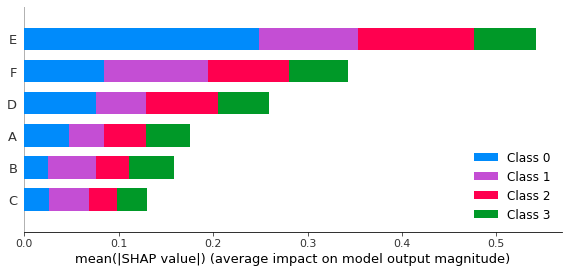

In [3]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


# Separate features and target variable
features = ['A', 'B', 'C', 'D', 'E', 'F']
X = df[features]
y = df['species']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Use SHAP to explain the model
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, X_train, plot_type="bar")



We will now calculate mean absolute shap values for each feature and find out the top 3 original features that explains the model as important features

In [4]:
import numpy as np

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values[0]), axis=0)
shap_importance_df = pd.DataFrame({
    'feature': features,
    'mean_abs_shap_value': mean_abs_shap_values
}).sort_values(by='mean_abs_shap_value', ascending=False)

# Select the top important features (let's say the top 3 for this example)
top_features = shap_importance_df['feature'].head(3).values
print(f'Top Important Features: {top_features}')


Top Important Features: ['E' 'F' 'D']


Let us now see if with these top identified features we can get a decent model

In [5]:
from sklearn.metrics import accuracy_score

# Use only the top important features for classification
X_top = df[top_features]
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Train a classifier on the top important features
clf_top = RandomForestClassifier(random_state=42)
clf_top.fit(X_train_top, y_train_top)
y_pred_top = clf_top.predict(X_test_top)
accuracy_top = accuracy_score(y_test_top, y_pred_top)
print(f'Accuracy with Top Features: {accuracy_top:.2f}')

Accuracy with Top Features: 0.94


Let us now use shap to see how the samples are explained with top features

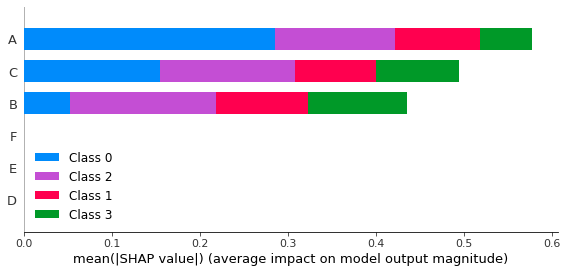

In [6]:

# Use SHAP to explain the model
explainer = shap.TreeExplainer(clf_top)
shap_values = explainer.shap_values(X_train)

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Using LIME


We will be using the same classifier model here and try to find out how the important original features contribute to samples of different labels


In [7]:
from lime.lime_tabular import LimeTabularExplainer

print(features)
print(np.unique(y))

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=np.unique(y),
    mode='classification'
)

['A', 'B', 'C', 'D', 'E', 'F']
['Bream' 'Pike' 'Roach' 'Smelt']


Let us create a helper fuction that will describe for different samples, which original features contribute how much


In [8]:


def find_explanation(label, clf, num_features=6):
    # Find the first instance of each label in the test set
    instance_index = X_test[y_test == label].index[0]
    instance = X_test.loc[instance_index].values
    
    # Explain the prediction
    exp = explainer.explain_instance(instance, clf.predict_proba, num_features=num_features)
    explanations[label] = exp

    # Print and plot the explanation
    print(f'Explanation for label {label}:')
    # exp.show_in_notebook(show_table=False, show_all=False)
    
    fig = exp.as_pyplot_figure()
    ax = fig.gca()
    ax.set_title(f'LIME Explanation for {label}')
    ax.set_xlabel('Feature Contribution')
    ax.set_ylabel('Feature')
    plt.show()

    # Get feature importance from LIME
    lime_importance = exp.as_list()
    print('LIME Feature Importance:', lime_importance)

    # Select top important features
    top_features = [feature for feature, _ in lime_importance][:3]
    print(f'Top Important Features for label {label}: {top_features}')


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Explanation for label Bream:


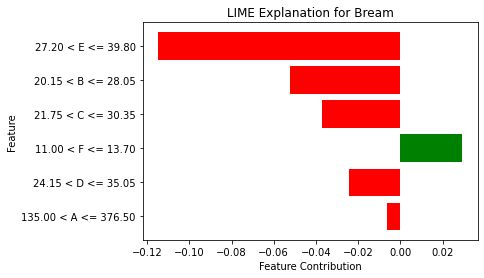

LIME Feature Importance: [('27.20 < E <= 39.80', -0.11487678753698426), ('20.15 < B <= 28.05', -0.05247366533201473), ('21.75 < C <= 30.35', -0.03705371738650568), ('11.00 < F <= 13.70', 0.029343872186321906), ('24.15 < D <= 35.05', -0.024348700055983087), ('135.00 < A <= 376.50', -0.006144831494597067)]
Top Important Features for label Bream: ['27.20 < E <= 39.80', '20.15 < B <= 28.05', '21.75 < C <= 30.35']


In [9]:
explanations = {}
find_explanation("Bream", clf)


Explanation for label Pike:


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


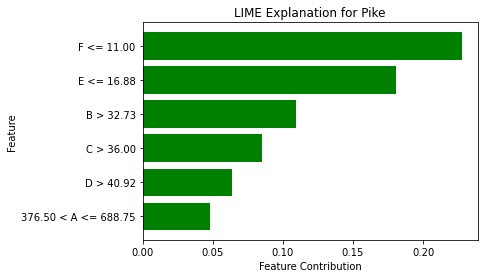

LIME Feature Importance: [('F <= 11.00', 0.22741890473217033), ('E <= 16.88', 0.18057887675071846), ('B > 32.73', 0.10927495394754387), ('C > 36.00', 0.0853264709306317), ('D > 40.92', 0.06385478769375255), ('376.50 < A <= 688.75', 0.048278488690446375)]
Top Important Features for label Pike: ['F <= 11.00', 'E <= 16.88', 'B > 32.73']


In [10]:
explanations = {}
find_explanation("Pike", clf)

Explanation for label Roach:


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


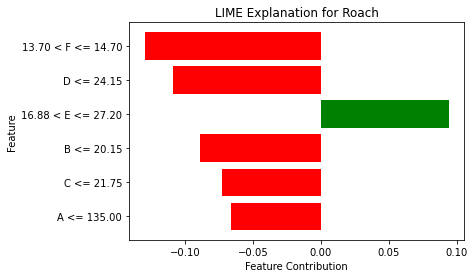

LIME Feature Importance: [('13.70 < F <= 14.70', -0.13013079267053881), ('D <= 24.15', -0.1094351884649331), ('16.88 < E <= 27.20', 0.0943268926799517), ('B <= 20.15', -0.08890348466689517), ('C <= 21.75', -0.0731049874754052), ('A <= 135.00', -0.06653803657160165)]
Top Important Features for label Roach: ['13.70 < F <= 14.70', 'D <= 24.15', '16.88 < E <= 27.20']


In [11]:
explanations = {}
find_explanation("Roach", clf)

Explanation for label Smelt:


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


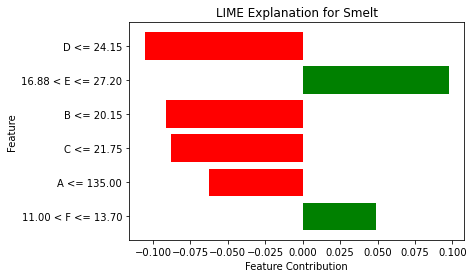

LIME Feature Importance: [('D <= 24.15', -0.10563093944865175), ('16.88 < E <= 27.20', 0.09760844755243168), ('B <= 20.15', -0.09152986756303177), ('C <= 21.75', -0.08802472434653924), ('A <= 135.00', -0.06262989153067741), ('11.00 < F <= 13.70', 0.04916812844965824)]
Top Important Features for label Smelt: ['D <= 24.15', '16.88 < E <= 27.20', 'B <= 20.15']


In [12]:
explanations = {}
find_explanation("Smelt", clf)

We will create a new LimeTabularExplainer instance to visualize how the reduced number of features explain the model's capacity

In [13]:
features = ['A','E','F']
X = df[features]
y = df['species']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
clf_top = RandomForestClassifier(random_state=42)
clf_top.fit(X_train, y_train)

# Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=np.unique(y),
    mode='classification'
)

Explanation for label Bream:


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


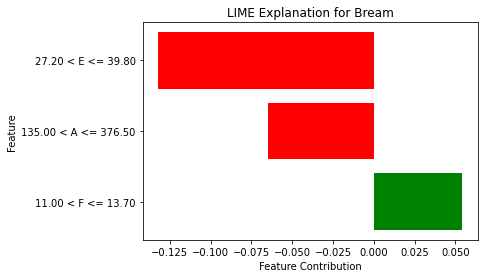

LIME Feature Importance: [('27.20 < E <= 39.80', -0.13234551641944775), ('135.00 < A <= 376.50', -0.06506511907721728), ('11.00 < F <= 13.70', 0.05418784709049762)]
Top Important Features for label Bream: ['27.20 < E <= 39.80', '135.00 < A <= 376.50', '11.00 < F <= 13.70']


In [14]:
find_explanation("Bream",clf_top,3)


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Explanation for label Pike:


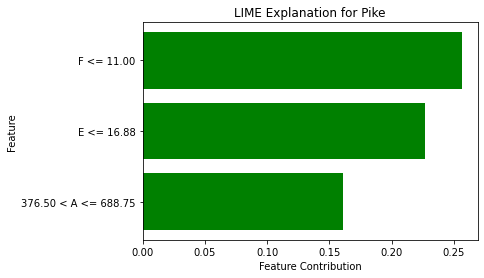

LIME Feature Importance: [('F <= 11.00', 0.25619388221271205), ('E <= 16.88', 0.2267752867396682), ('376.50 < A <= 688.75', 0.16071184702546015)]
Top Important Features for label Pike: ['F <= 11.00', 'E <= 16.88', '376.50 < A <= 688.75']


In [15]:
find_explanation("Pike",clf_top,3)


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Explanation for label Roach:


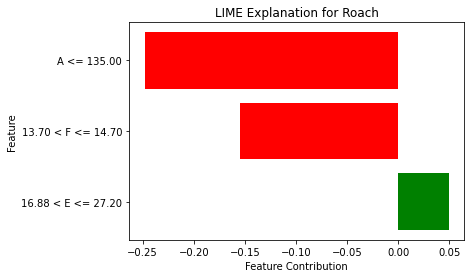

LIME Feature Importance: [('A <= 135.00', -0.2482175800810882), ('13.70 < F <= 14.70', -0.15528594629080966), ('16.88 < E <= 27.20', 0.04947808633855253)]
Top Important Features for label Roach: ['A <= 135.00', '13.70 < F <= 14.70', '16.88 < E <= 27.20']


In [16]:
find_explanation("Roach",clf_top,3)


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Explanation for label Smelt:


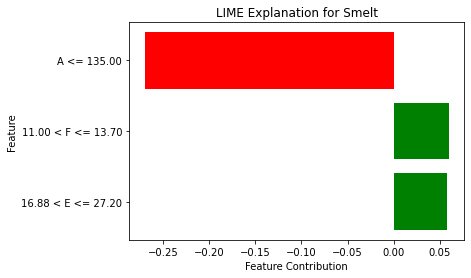

LIME Feature Importance: [('A <= 135.00', -0.27031883616211905), ('11.00 < F <= 13.70', 0.05997613039027536), ('16.88 < E <= 27.20', 0.0578395495828744)]
Top Important Features for label Smelt: ['A <= 135.00', '11.00 < F <= 13.70', '16.88 < E <= 27.20']


In [17]:
find_explanation("Smelt",clf_top,3)
